In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import os
import sys
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
sys.path.insert(1, '../code')
from geometric_features import GeometricFeaturizer, geo_name
from scalar_features import ScalarFeaturizer, scalar_name
from read_halos import SimulationReader
from fit import LinearFitter
from neural_net import NeuralNet, NNFitter
import plotter
import utils
import feature_importance

In [2]:
# sim / halo info
base_dir = '/scratch/ksf293/equivariant-cosmology/data'
snap_num_str = '099' # z = 0
sim_name = 'TNG100-1'
sim_name_dark = 'TNG100-1-Dark'
# sim_name = 'TNG50-4'
# sim_name_dark = 'TNG50-4-Dark'
halo_dir = f'../data/halos/halos_{sim_name}'
halo_tag = '_nstarpartmin50_twin'
fn_dark_halo_arr = f'{halo_dir}/halos_{sim_name}{halo_tag}.npy'
mass_multiplier = 1e10
log_mass_shift = 10

In [3]:
# geo info
geo_dir = f'../data/geometric_features/geometric_features_{sim_name}'
geo_tag = '_xminPEsub_rall'
fn_geo_features = f'{geo_dir}/geometric_features{halo_tag}{geo_tag}.npy'
print(fn_geo_features)

../data/geometric_features/geometric_features_TNG100-1/geometric_features_nstarpartmin50_twin_xminPEsub_rall.npy


In [4]:
geo_featurizer = GeometricFeaturizer()
geo_featurizer.load_features(fn_geo_features)

In [5]:
n_groups = [[0,1,2], [3,4,5,6,7], [8,9,10]]
geo_feature_arr_rebinned = utils.rebin_geometric_features(geo_featurizer.geo_feature_arr, n_groups)
geo_feature_arr_pseudo = utils.transform_pseudotensors(geo_feature_arr_rebinned)

In [6]:
sim_reader = SimulationReader(base_dir, sim_name, sim_name_dark, snap_num_str)
sim_reader.load_dark_halo_arr(fn_dark_halo_arr)
sim_reader.read_simulations()

In [7]:
sim_reader.add_catalog_property_to_halos('mass_hydro_subhalo_star')
sim_reader.add_catalog_property_to_halos('m200m')
sim_reader.add_catalog_property_to_halos('r200m')
sim_reader.add_catalog_property_to_halos('v200m')

sim_reader.add_catalog_property_to_halos('x_minPE')
sim_reader.add_catalog_property_to_halos('x_minPE_hydro')

In [8]:
m_stellar = np.array([dark_halo.catalog_properties['mass_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])
m_200m = np.array([dark_halo.catalog_properties['m200m'] for dark_halo in sim_reader.dark_halo_arr])
r_200m = np.array([dark_halo.catalog_properties['r200m'] for dark_halo in sim_reader.dark_halo_arr])
v_200m = np.array([dark_halo.catalog_properties['v200m'] for dark_halo in sim_reader.dark_halo_arr])
log_m_stellar = np.log10(m_stellar)
log_m_200m = np.log10(m_200m)
log_r_200m = np.log10(r_200m)
N_halos = len(sim_reader.dark_halo_arr)
print('N_halos:', N_halos)

N_halos: 19810


## Split train-val-test

In [9]:
frac_train = 0.70
frac_test = 0.15

random_ints = np.array([dark_halo.random_int for dark_halo in sim_reader.dark_halo_arr])
idx_train, idx_val, idx_test = utils.split_train_val_test(random_ints, frac_train=frac_train, frac_test=frac_test)

print(len(idx_train), len(idx_test), len(idx_val))

13867 2972 2971


In [10]:
log_m_200m_train = log_m_200m[idx_train]
log_m_stellar_train = log_m_stellar[idx_train]

# Check out SFR / sSFR

In [11]:
x_label_name = 'm_stellar'
y_label_name = 'sfr'

Units of SFR: Msun/year (note: no little h!)

In [12]:
sim_reader.add_catalog_property_to_halos('sfr_hydro_subhalo_star')
sfr_orig = np.array([dark_halo.catalog_properties['sfr_hydro_subhalo_star'] for dark_halo in sim_reader.dark_halo_arr])

In [13]:
idx_zerosfr = np.where(sfr_orig==0)[0]
idx_sfing = np.where(sfr_orig>0)[0]
print(len(sfr_orig), len(idx_zerosfr), len(idx_sfing))

19810 796 19014


In [14]:
sfr_zero = 1e-3

In [15]:
sfr = sfr_orig.copy()
sfr[idx_zerosfr] = sfr_zero

In [16]:
log_sfr = np.log10(sfr)

0.0 99.81936


Text(0, 0.5, 'number per bin')

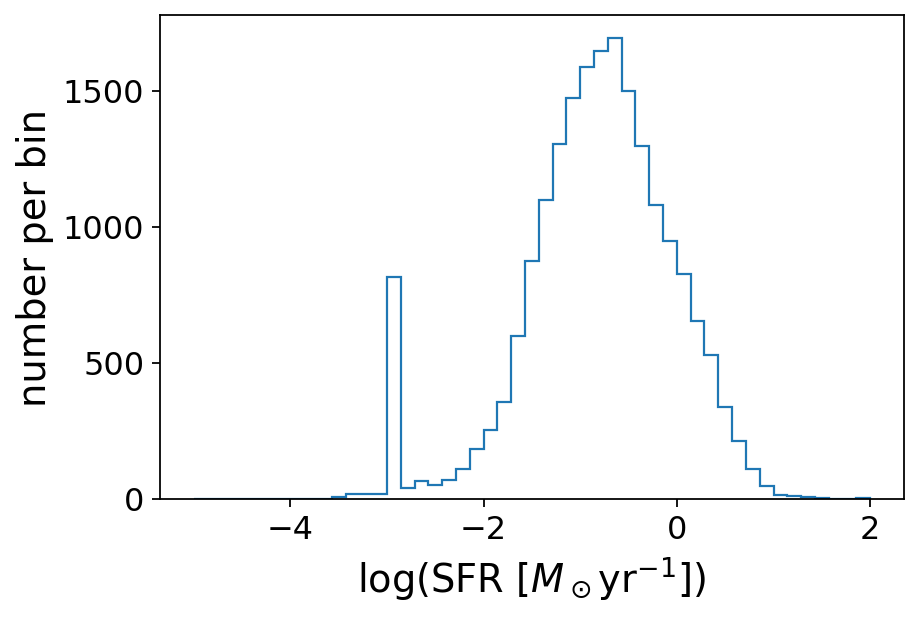

In [17]:
y_label_sfr=r'log(SFR $[M_\odot \mathrm{yr}^{-1}]$)'
print(np.min(sfr_orig), np.max(sfr))
bins = np.linspace(-5, 2)
_ = plt.hist(log_sfr, bins=bins, histtype='step')
plt.xlabel(y_label_sfr)
plt.ylabel('number per bin')

## Get uncertainites in terms of SFR:

In [18]:
# these are uncertainties in dex so they are on log_sfr! (same deal as stellar mass)
uncertainties_genel2019_sfr = utils.get_uncertainties_genel2019('sfr', log_m_stellar+log_mass_shift, sim_name)

In [19]:
uncertainties_poisson_sfr = utils.get_uncertainties_poisson_sfr(sfr, sfr_zero)

In [20]:
uncertainties_genel2019_poisson_sfr = np.sqrt(uncertainties_genel2019_sfr**2 + uncertainties_poisson_sfr**2)

In [21]:
uncertainties_genel2019_poisson_sfr_train = uncertainties_genel2019_poisson_sfr[idx_train]

Text(0, 0.5, 'log(SFR $\\: [M_\\odot \\, \\mathrm{yr}^{-1}]$)')

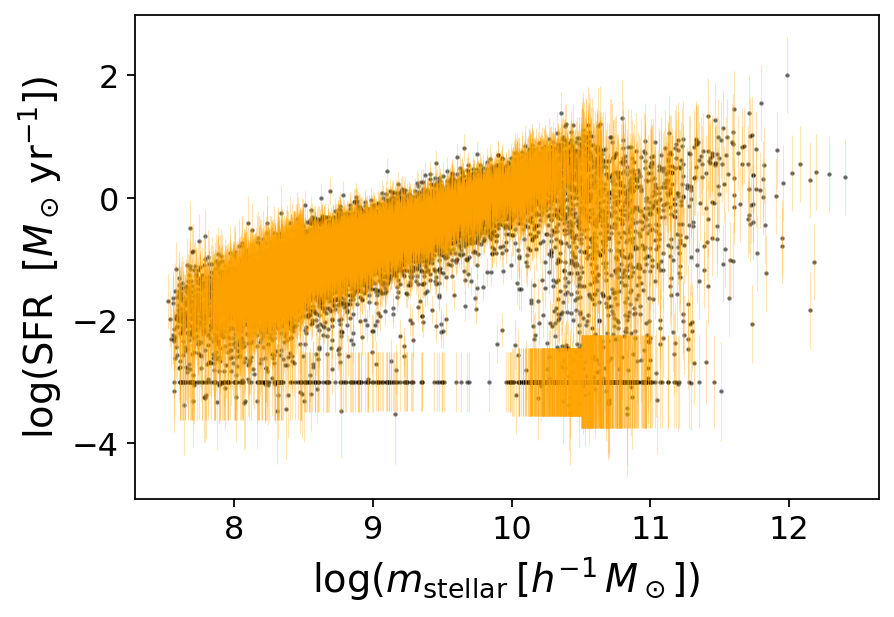

In [22]:
plt.errorbar(log_m_stellar+log_mass_shift, log_sfr, yerr=uncertainties_genel2019_poisson_sfr, color='orange', 
             lw=0, elinewidth=0.5, alpha=0.3)#, markersize=20, markerfacecolor='k')
plt.scatter(log_m_stellar+log_mass_shift, log_sfr, s=1, c='k', alpha=0.5)

plt.xlabel(utils.label_dict[x_label_name])
plt.ylabel(utils.label_dict[y_label_name])

## Powerlaw fit to SFR

In [23]:
log_sfr_train = log_sfr[idx_train]


In [24]:
idx_nonzerosfr = (log_sfr_train > np.log10(sfr_zero))
idx_lowm = (log_m_stellar_train+log_mass_shift < 10.5)
idx_fit = idx_nonzerosfr & idx_lowm

params_initial_guess = [1,0]
y_val_current_powerlaw_fit_sfr_train_sfing, params_best_fit = utils.fit_function(
                                                        utils.power_law,
                                                        log_m_stellar_train[idx_fit], log_sfr_train[idx_fit], 
                                                        uncertainties_genel2019_poisson_sfr_train[idx_fit], 
                                                        params_initial_guess)
y_val_current_powerlaw_fit_sfr = utils.power_law(log_m_stellar, *params_best_fit)
y_val_current_powerlaw_fit_sfr_train = y_val_current_powerlaw_fit_sfr[idx_train]

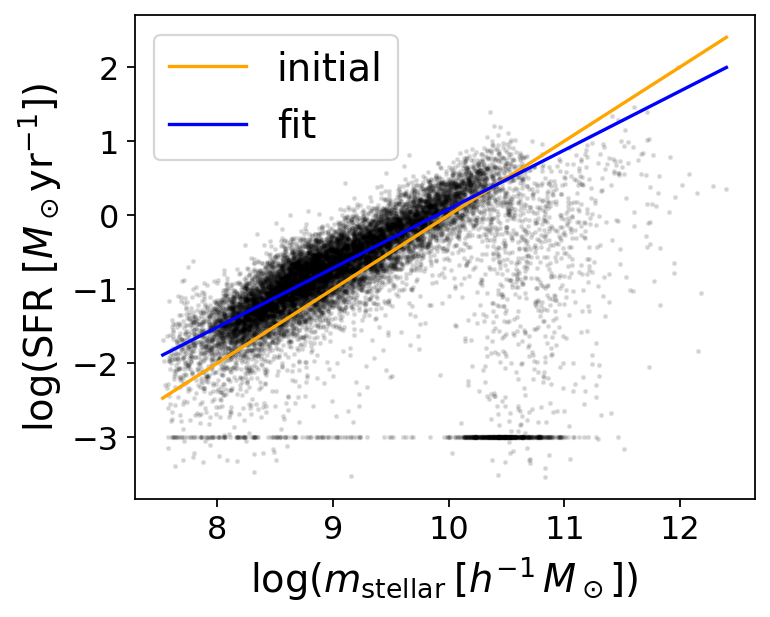

In [25]:
plt.figure(figsize=(5,4))
plt.scatter(log_m_stellar_train+log_mass_shift, log_sfr_train, s=2, c='k', alpha=0.1)

idx_mstellar = np.argsort(log_m_stellar_train)
y_initial_train = utils.power_law(log_m_stellar_train, *params_initial_guess)
plt.plot(log_m_stellar_train[idx_mstellar]+log_mass_shift, y_initial_train[idx_mstellar], color='orange', label='initial')
plt.plot(log_m_stellar_train[idx_mstellar]+log_mass_shift, y_val_current_powerlaw_fit_sfr_train[idx_mstellar], color='blue', label='fit')

plt.xlabel(utils.label_dict['m_stellar'])
plt.ylabel(y_label_sfr)
plt.legend()

## Now convert to sSFR

In [26]:
y_label_name='ssfr'

In [27]:
# little h via https://www.tng-project.org/data/downloads/TNG100-1/
def sfr_to_ssfr(sfr_arr, m_stellar_arr, mass_multiplier=1e10):
    h = 0.6774  
    m_stellar_Msun_arr = (m_stellar_arr*mass_multiplier)/h
    ssfr_arr = sfr_arr/m_stellar_Msun_arr
    return ssfr_arr

In [28]:
ssfr = sfr_to_ssfr(sfr, m_stellar, mass_multiplier=mass_multiplier)
log_ssfr = np.log10(ssfr)

Text(0, 0.5, 'number per bin')

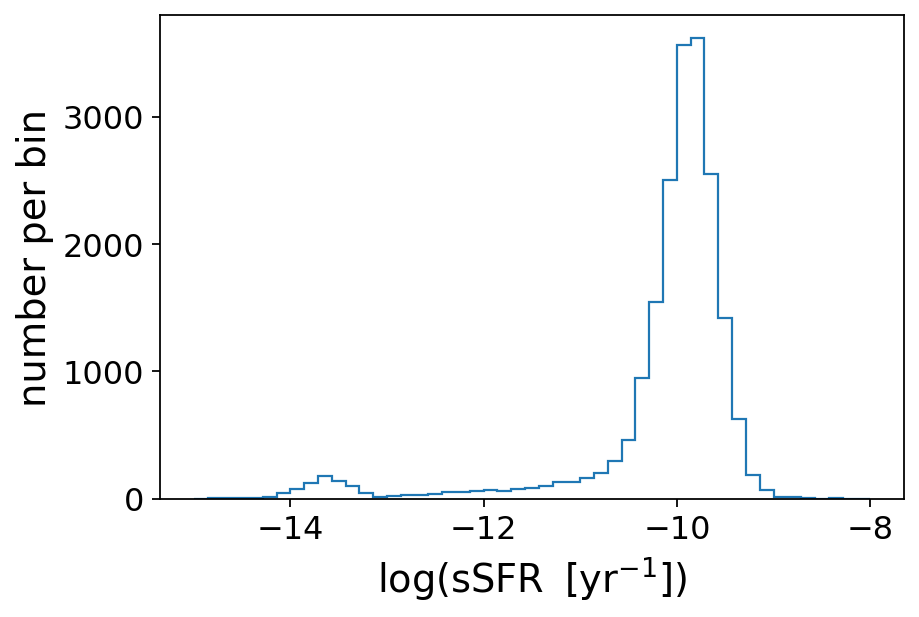

In [29]:
bins = np.linspace(-15, -8)
_ = plt.hist(log_ssfr, bins=bins, histtype='step')
plt.xlabel(utils.label_dict[y_label_name])
plt.ylabel('number per bin')

In [30]:
log_ssfr_train = log_ssfr[idx_train]

In [31]:
# little h via https://www.tng-project.org/data/downloads/TNG100-1/
def log_sfr_to_log_ssfr(log_sfr_arr, m_stellar_arr, mass_multiplier=1e10):
    h = 0.6774  
    m_stellar_Msun_arr = (m_stellar_arr*mass_multiplier)/h
    return log_sfr_arr - np.log10(m_stellar_Msun_arr)

In [32]:
# because we're working in log errors, the multiplicative factor of M/h is a constant that 
# just drops out with the derivative; so the uncertainties are the same! i think ?!
def uncertainty_log_sfr_to_uncertainty_log_ssfr(uncertainty_log_sfr_arr, mass_multiplier=1e10):
    return uncertainty_log_sfr_arr

In [33]:
# is this the right thing to do??
y_val_current_powerlaw_fit_ssfr = log_sfr_to_log_ssfr(y_val_current_powerlaw_fit_sfr, m_stellar)
uncertainties_genel2019_poisson_ssfr = uncertainty_log_sfr_to_uncertainty_log_ssfr(uncertainties_genel2019_poisson_sfr)

In [34]:
uncertainties_genel2019_poisson_sfr

array([0.62006829, 0.62005733, 0.6303296 , ..., 0.22214239, 0.4447012 ,
       0.4641176 ])

In [35]:
uncertainties_genel2019_poisson_ssfr

array([0.62006829, 0.62005733, 0.6303296 , ..., 0.22214239, 0.4447012 ,
       0.4641176 ])

In [36]:
log_ssfr

array([-12.2211  , -11.935229, -14.156546, ...,  -9.606798,  -9.918212,
       -10.088883], dtype=float32)

Text(0, 0.5, 'log(sSFR $\\: [\\mathrm{yr}^{-1}]$)')

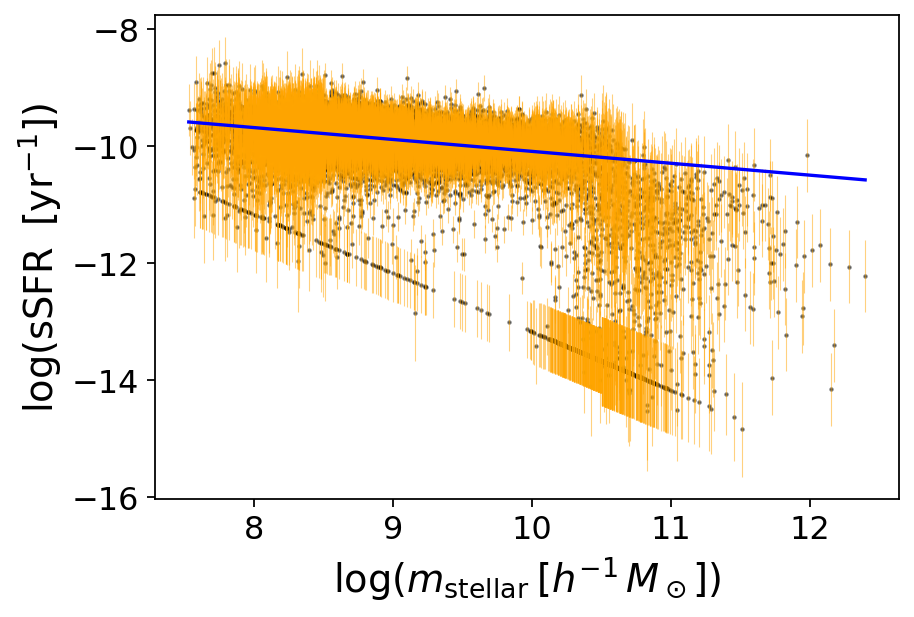

In [37]:
plt.errorbar(log_m_stellar_train+log_mass_shift, log_ssfr_train, 
              yerr=uncertainties_genel2019_poisson_ssfr[idx_train], color='orange', 
              lw=0, elinewidth=0.5, alpha=0.5)#, markersize=20, markerfacecolor='k')
plt.scatter(log_m_stellar_train+log_mass_shift, log_ssfr_train, s=1, c='k', alpha=0.5)

plt.plot(log_m_stellar_train[idx_mstellar]+log_mass_shift, y_val_current_powerlaw_fit_ssfr[idx_train][idx_mstellar], 
         color='blue', label='fit')

plt.xlabel(utils.label_dict[x_label_name])
plt.ylabel(utils.label_dict[y_label_name])

# Try fit!

In [38]:
# scalar info
scalar_featurizer = ScalarFeaturizer(geo_feature_arr_pseudo)
scalar_featurizer.rescale_geometric_features(m_200m, r_200m, v_200m)

# m_dm is in units of 1/1e10, this M_tot value is already in the units we're using internally (log(M/1e10))
x_features_extra = np.vstack((m_200m, r_200m, v_200m)).T
x_features_extra = np.log10(x_features_extra)   

In [39]:
m_order_max = 2
x_order_max = 4
v_order_max = 4
scalar_tag = f'_3bins_pseudo_rescaled_mord{m_order_max}_xord{x_order_max}_vord{v_order_max}'
scalar_dir = f'../data/scalar_features/scalar_features_{sim_name}'
fn_scalar_features = f'{scalar_dir}/scalar_features{halo_tag}{geo_tag}{scalar_tag}.npy'

print('loading')
scalar_featurizer.load_features(fn_scalar_features)
print('loaded')

loading
loaded


0.34503696419148316


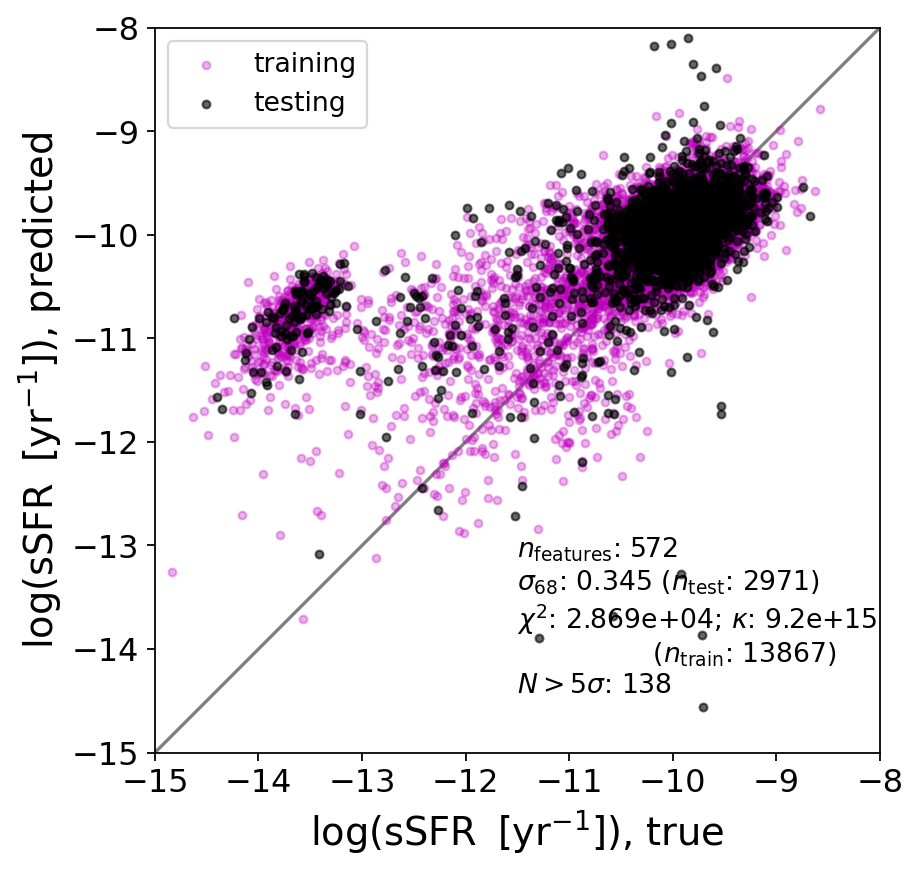

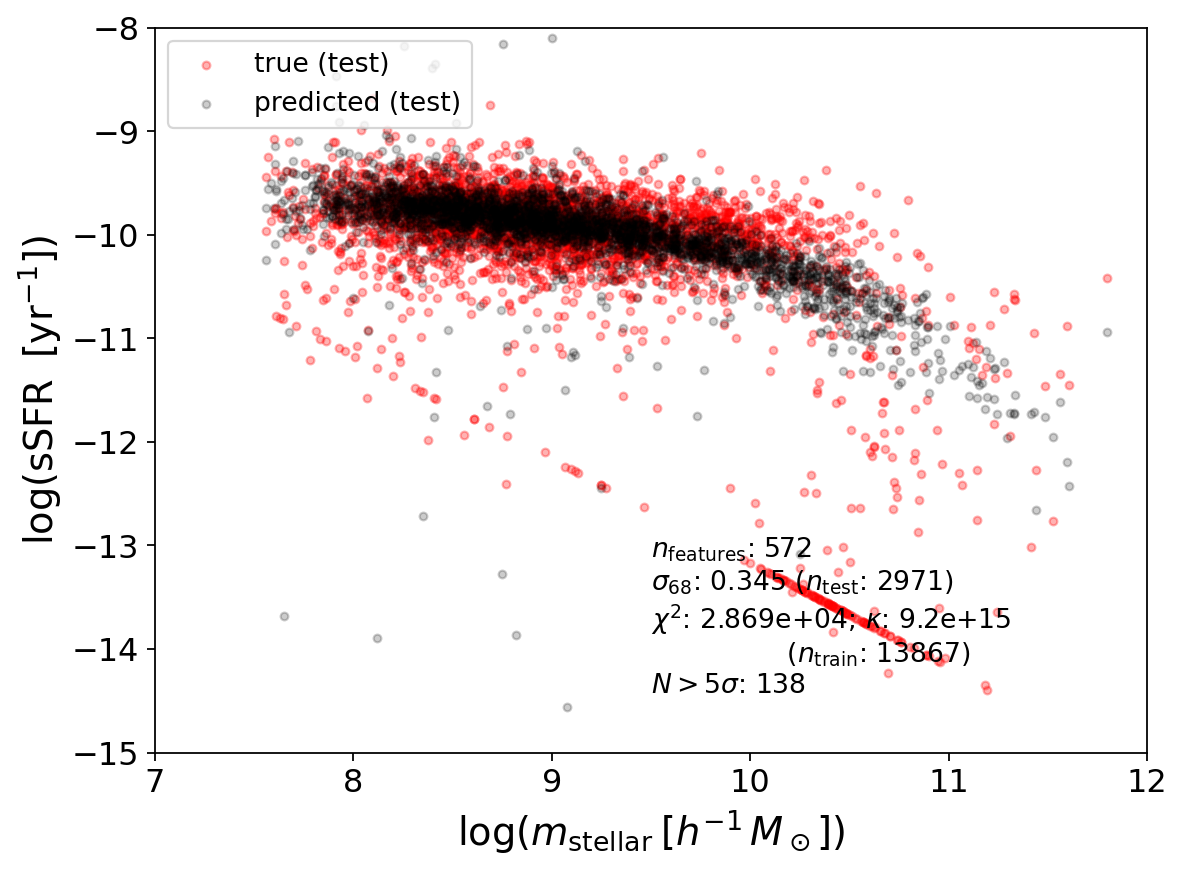

In [40]:
x_label_name = 'm_stellar'

fitter_all = LinearFitter(scalar_featurizer.scalar_features, log_ssfr, 
                    y_val_current_powerlaw_fit_ssfr, uncertainties=uncertainties_genel2019_poisson_ssfr,
                    x_features_extra=x_features_extra)
fitter_all.split_train_test(idx_train, idx_val)
fitter_all.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter_all.predict_test()
plotter.plot_fits(x_label_name, y_label_name, fitter_all, log_m_stellar, x_lim=(7, 12),  y_lim=(-15, -8))
error_all, _ = utils.compute_error(fitter_all, test_error_type='percentile')
print(error_all)

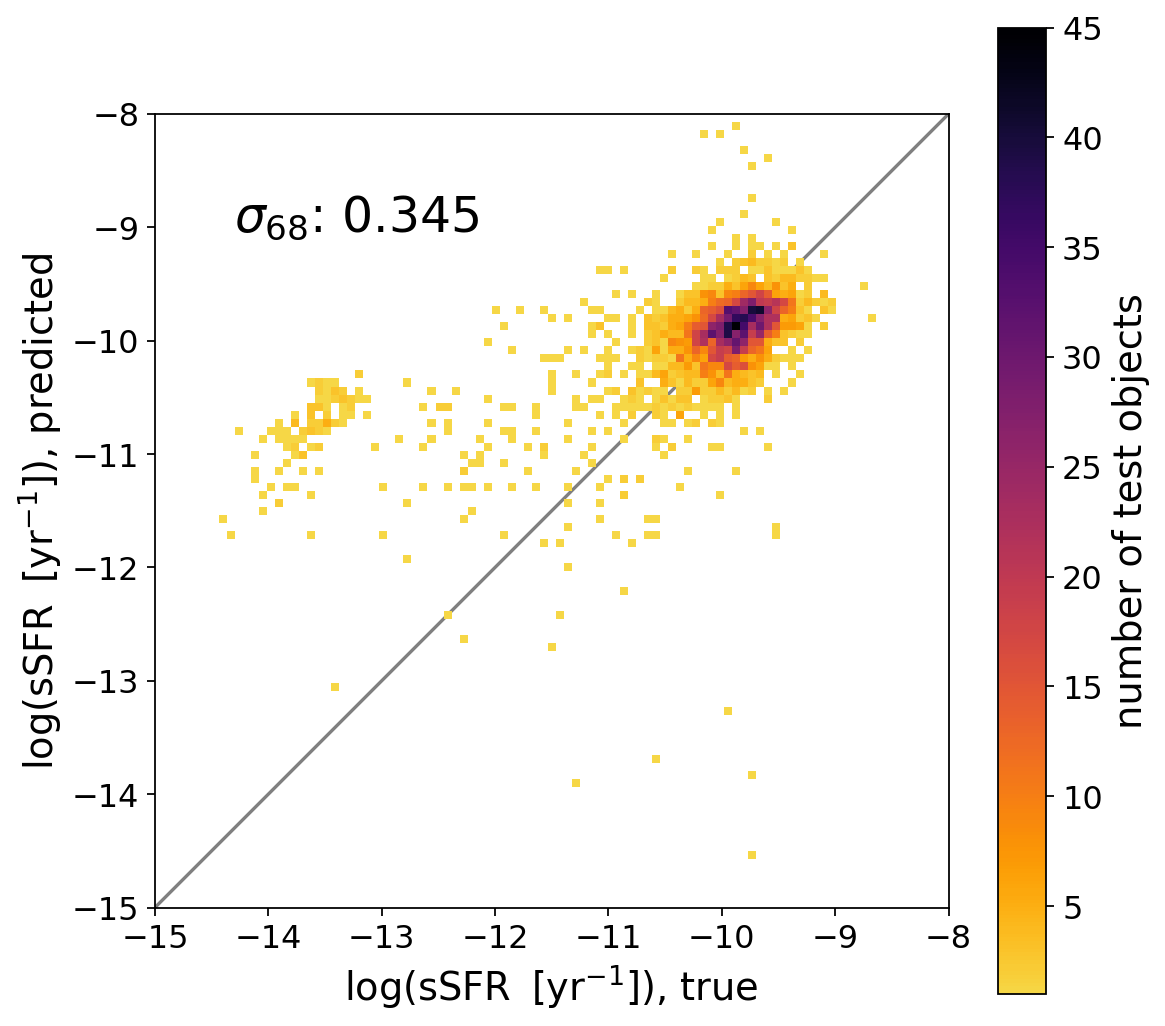

In [41]:
y_true = fitter_all.y_scalar_test
y_pred = fitter_all.y_scalar_pred
error_str = fr"$\sigma_{{68}}$: {error_all:.3f}"
plotter.plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str,
                               x_lim=(-15, -8),  y_lim=(-15, -8))

In [42]:
y_val_current_powerlaw_fit_ssfr_val = y_val_current_powerlaw_fit_ssfr[idx_val]

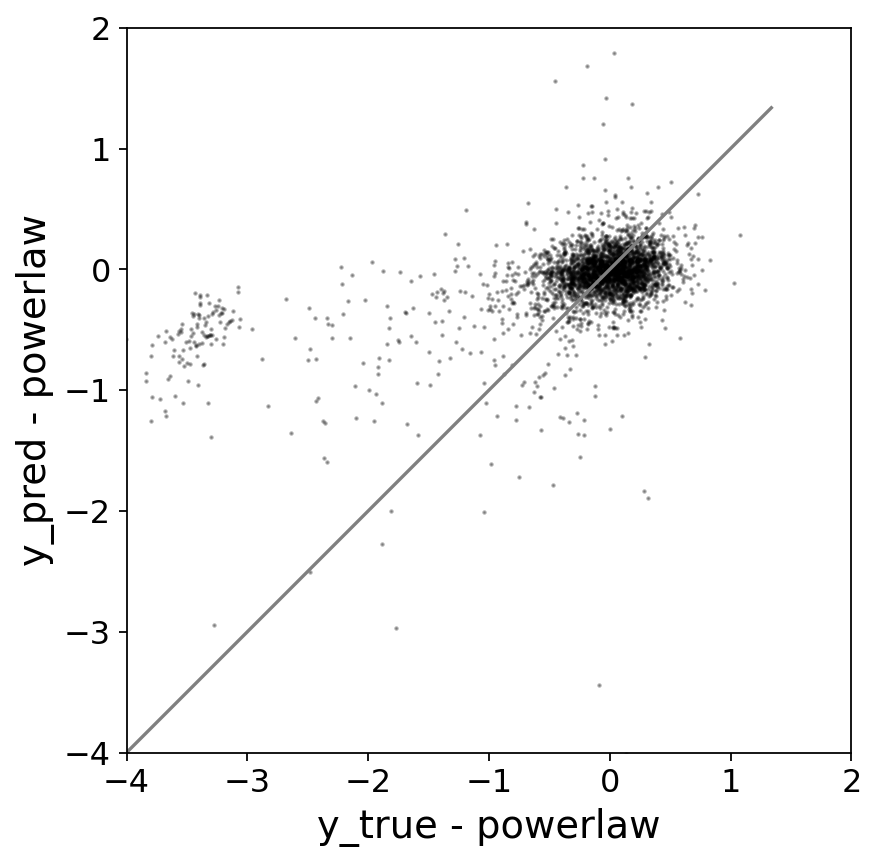

In [43]:
plt.figure(figsize=(8,6))
plt.scatter(y_true-y_val_current_powerlaw_fit_ssfr_val, y_pred-y_val_current_powerlaw_fit_ssfr_val, s=1, alpha=0.3, c='k')
xx = np.linspace(*plt.xlim())
plt.plot(xx, xx, color='grey')
plt.xlim(-4, 2)
plt.ylim(-4, 2)
plt.xlabel('y_true - powerlaw')
plt.ylabel('y_pred - powerlaw')
ax = plt.gca()
ax.set_aspect('equal')

### No powerlaw

0.34503696419148316


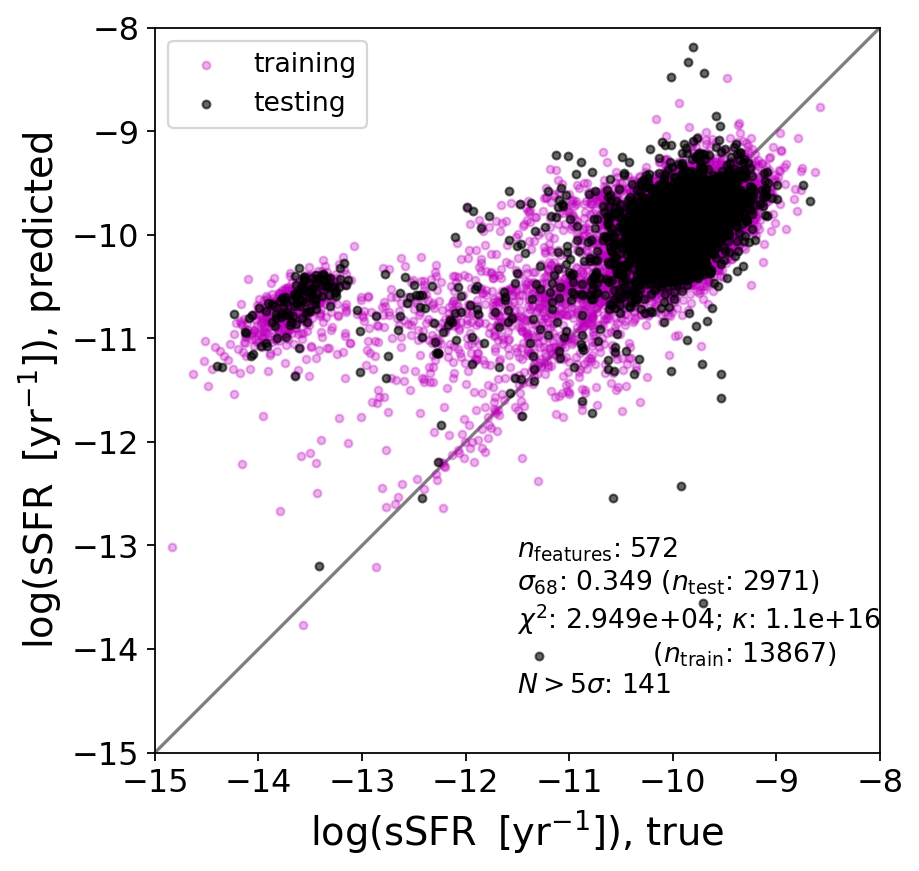

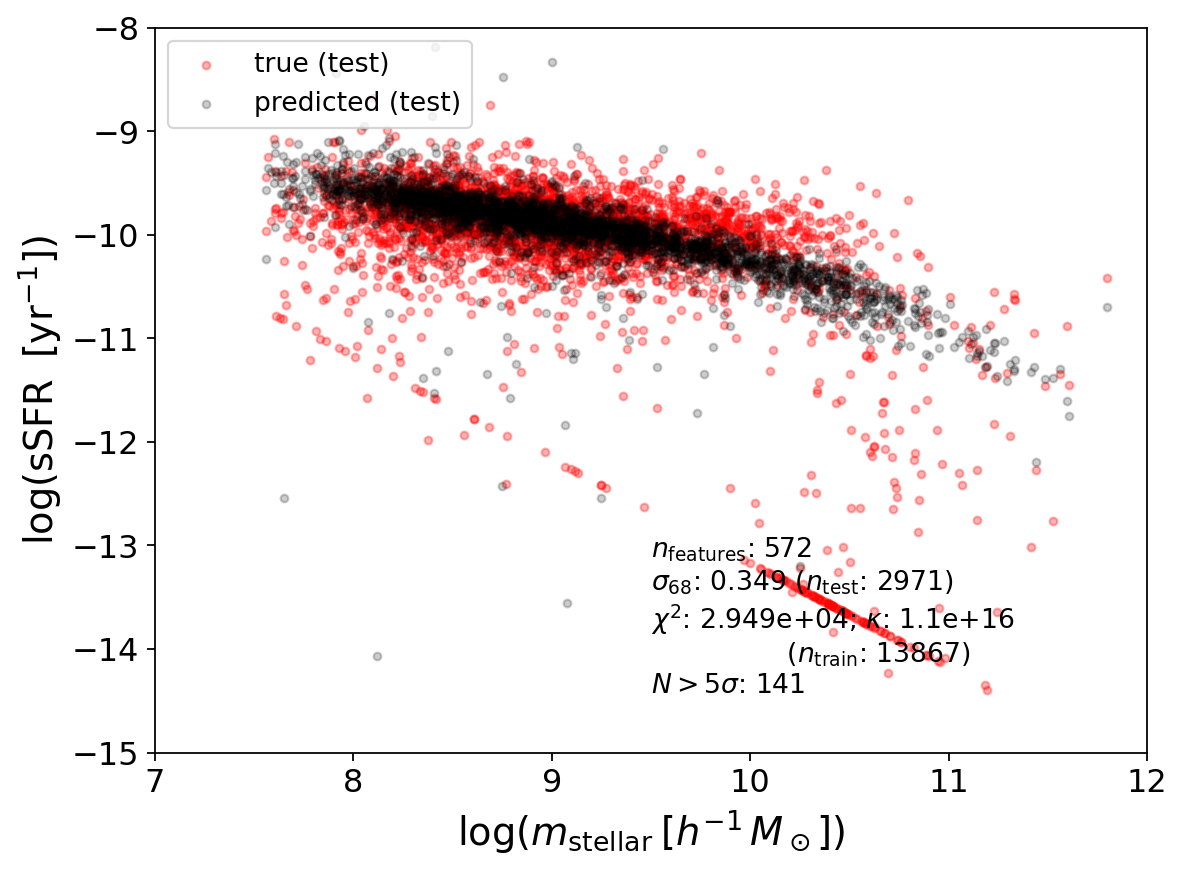

In [44]:
x_label_name = 'm_stellar'

ones = np.ones(len(log_ssfr))
fitter_all_nopl = LinearFitter(scalar_featurizer.scalar_features, log_ssfr, 
                    ones, uncertainties=uncertainties_genel2019_poisson_ssfr,
                    x_features_extra=x_features_extra)
fitter_all_nopl.split_train_test(idx_train, idx_val)
fitter_all_nopl.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter_all_nopl.predict_test()
plotter.plot_fits(x_label_name, y_label_name, fitter_all_nopl, log_m_stellar, x_lim=(7, 12),  y_lim=(-15, -8))
error_all_nopl, _ = utils.compute_error(fitter_all_nopl, test_error_type='percentile')
print(error_all)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:285: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


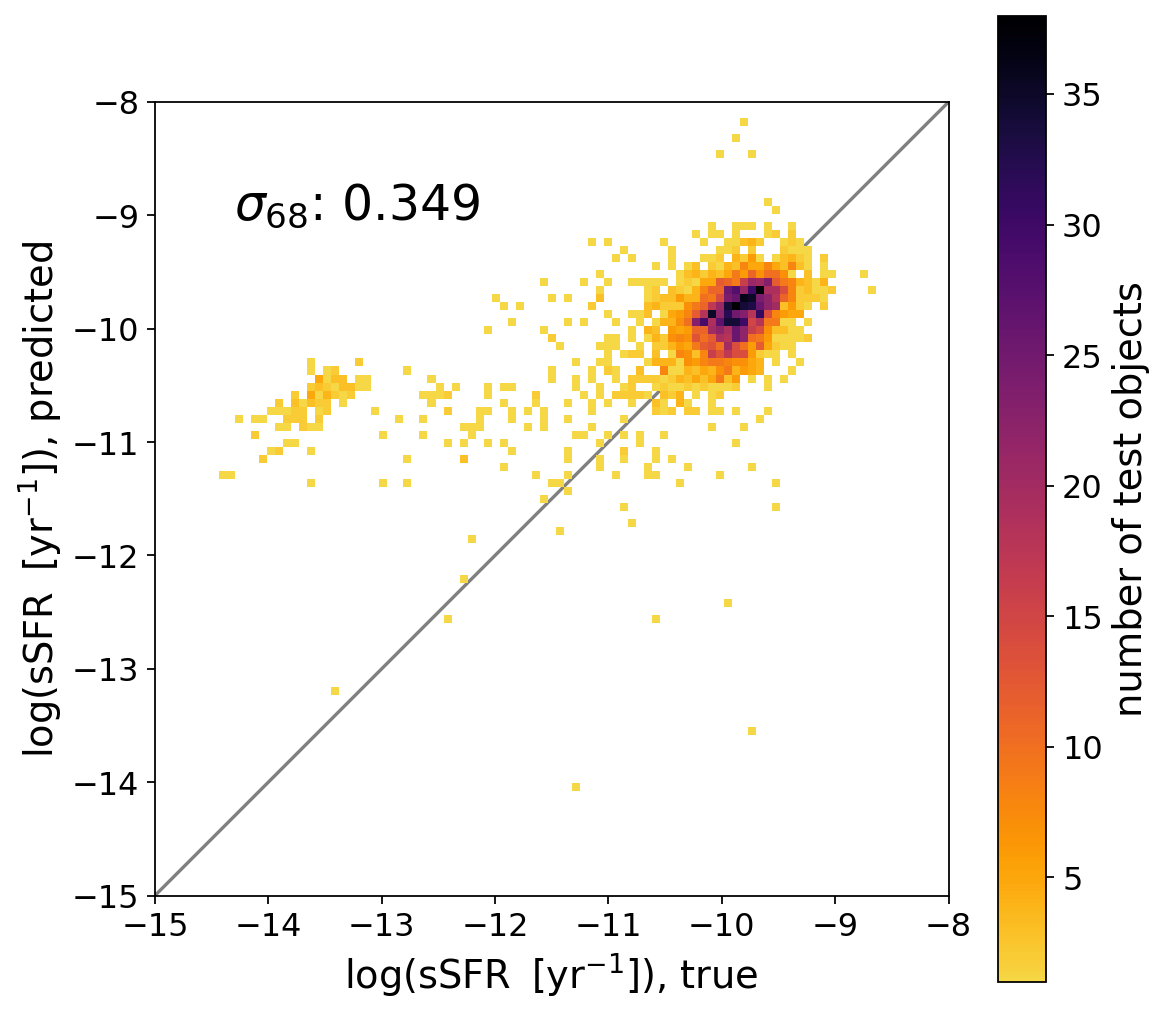

In [46]:
y_true = fitter_all_nopl.y_scalar_test
y_pred = fitter_all_nopl.y_scalar_pred
error_str = fr"$\sigma_{{68}}$: {error_all_nopl:.3f}"
plotter.plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str,
                               x_lim=(-15, -8),  y_lim=(-15, -8))

# SFR over 1 Gyr

In [54]:
x_label_name = 'm_stellar'
y_label_name = 'sfr1'

Units of SFR: Msun/year (note: no little h!)

In [63]:
sim_reader.add_catalog_property_to_halos('sfr_hydro_subhalo_1Gyr')
sfr1_orig = np.array([dark_halo.catalog_properties['sfr_hydro_subhalo_1Gyr'] for dark_halo in sim_reader.dark_halo_arr])

In [64]:
idx_zerosfr = np.where(sfr1_orig==0)[0]
idx_sfing = np.where(sfr1_orig>0)[0]
print(len(sfr1_orig), len(idx_zerosfr), len(idx_sfing))

19810 625 19185


In [65]:
sfr1_zero = 1e-3

In [66]:
sfr1 = sfr1_orig.copy()
sfr1[idx_zerosfr] = sfr1_zero

In [67]:
log_sfr1 = np.log10(sfr1)

0.0 99.81936


Text(0, 0.5, 'number per bin')

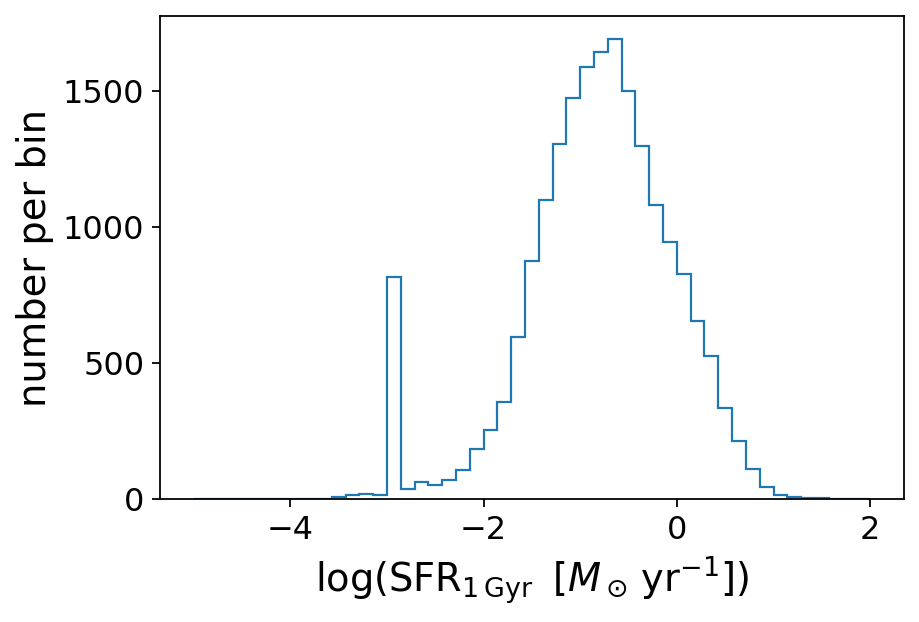

In [70]:
#y_label_sfr1=r'log(SFR$_\mathrm{1\,Gyr}$ $[M_\odot \mathrm{yr}^{-1}]$)'
print(np.min(sfr_orig), np.max(sfr))
bins = np.linspace(-5, 2)
_ = plt.hist(log_sfr, bins=bins, histtype='step')
plt.xlabel(utils.label_dict[y_label_name])
plt.ylabel('number per bin')

In [74]:
uncertainties_genel2019_sfr1 = utils.get_uncertainties_genel2019('sfr1', log_m_stellar+log_mass_shift, sim_name)
uncertainties_poisson_sfr1 = utils.get_uncertainties_poisson_sfr(sfr1, sfr1_zero)
uncertainties_genel2019_poisson_sfr1 = np.sqrt(uncertainties_genel2019_sfr1**2 + uncertainties_poisson_sfr1**2)
uncertainties_genel2019_poisson_ssfr1 = uncertainty_log_sfr_to_uncertainty_log_ssfr(uncertainties_genel2019_poisson_sfr1) 

In [75]:
ssfr1 = sfr_to_ssfr(sfr1, m_stellar, mass_multiplier=mass_multiplier)
log_ssfr1 = np.log10(ssfr1)

0.34503696419148316


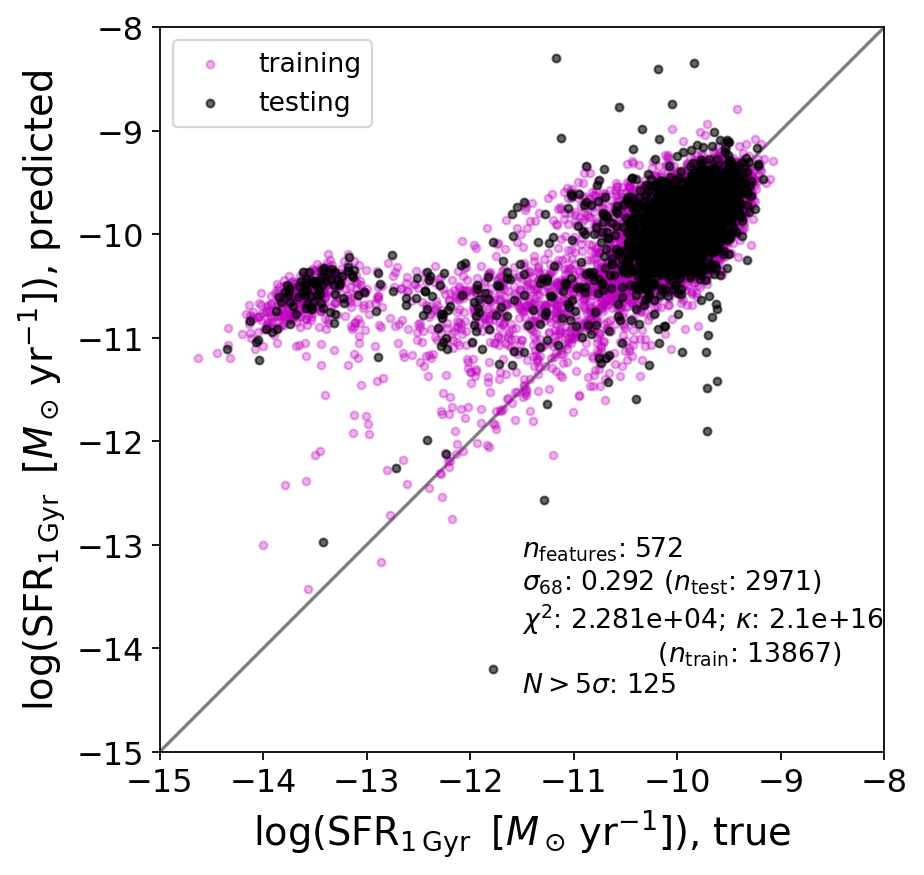

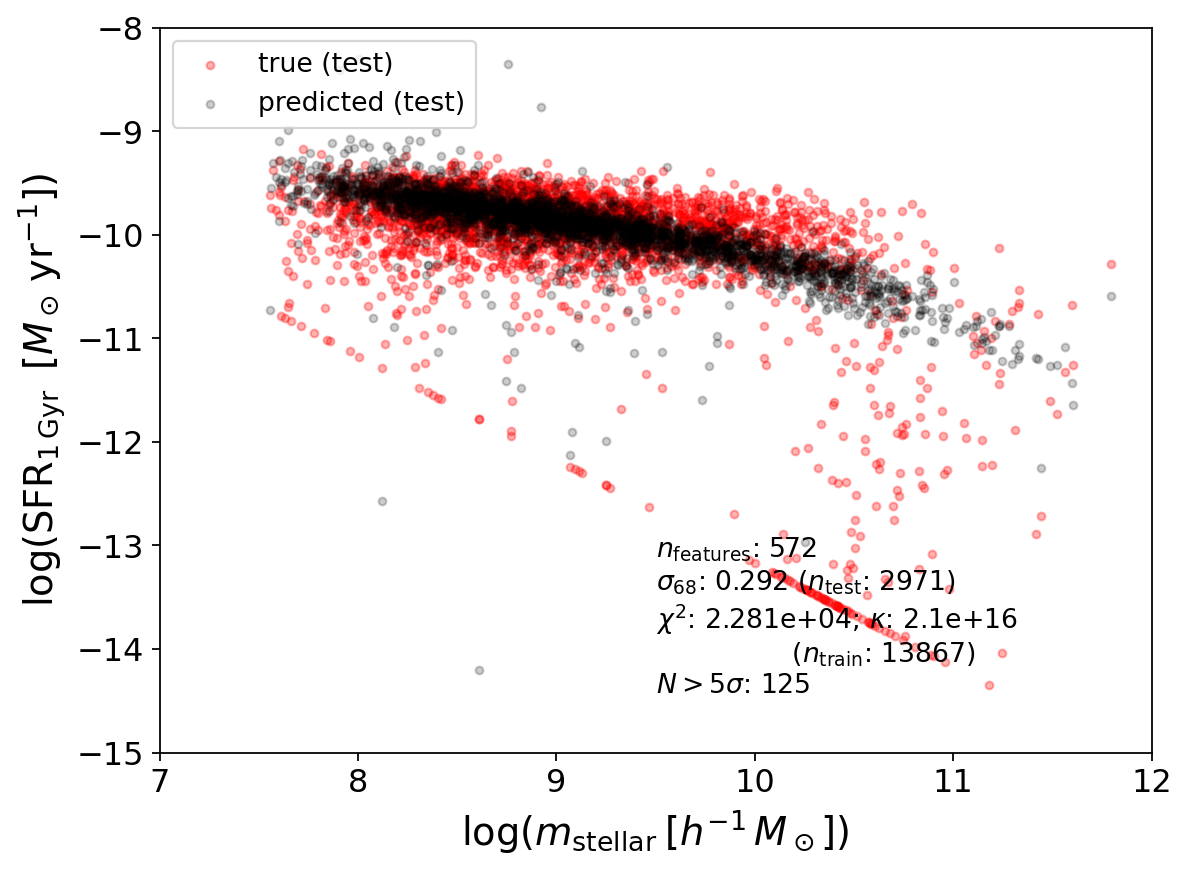

In [76]:
x_label_name = 'm_stellar'

ones = np.ones(len(log_ssfr1))
fitter_all_nopl = LinearFitter(scalar_featurizer.scalar_features, log_ssfr1, 
                    ones, uncertainties=uncertainties_genel2019_poisson_ssfr1,
                    x_features_extra=x_features_extra)
fitter_all_nopl.split_train_test(idx_train, idx_val)
fitter_all_nopl.scale_and_fit(rms_x=True, log_x=False, log_y=False)
fitter_all_nopl.predict_test()
plotter.plot_fits(x_label_name, y_label_name, fitter_all_nopl, log_m_stellar, x_lim=(7, 12),  y_lim=(-15, -8))
error_all_nopl, _ = utils.compute_error(fitter_all_nopl, test_error_type='percentile')
print(error_all)

/home/ksf293/equivariant-cosmology/notebooks/../code/utils.py:285: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=newcmap)


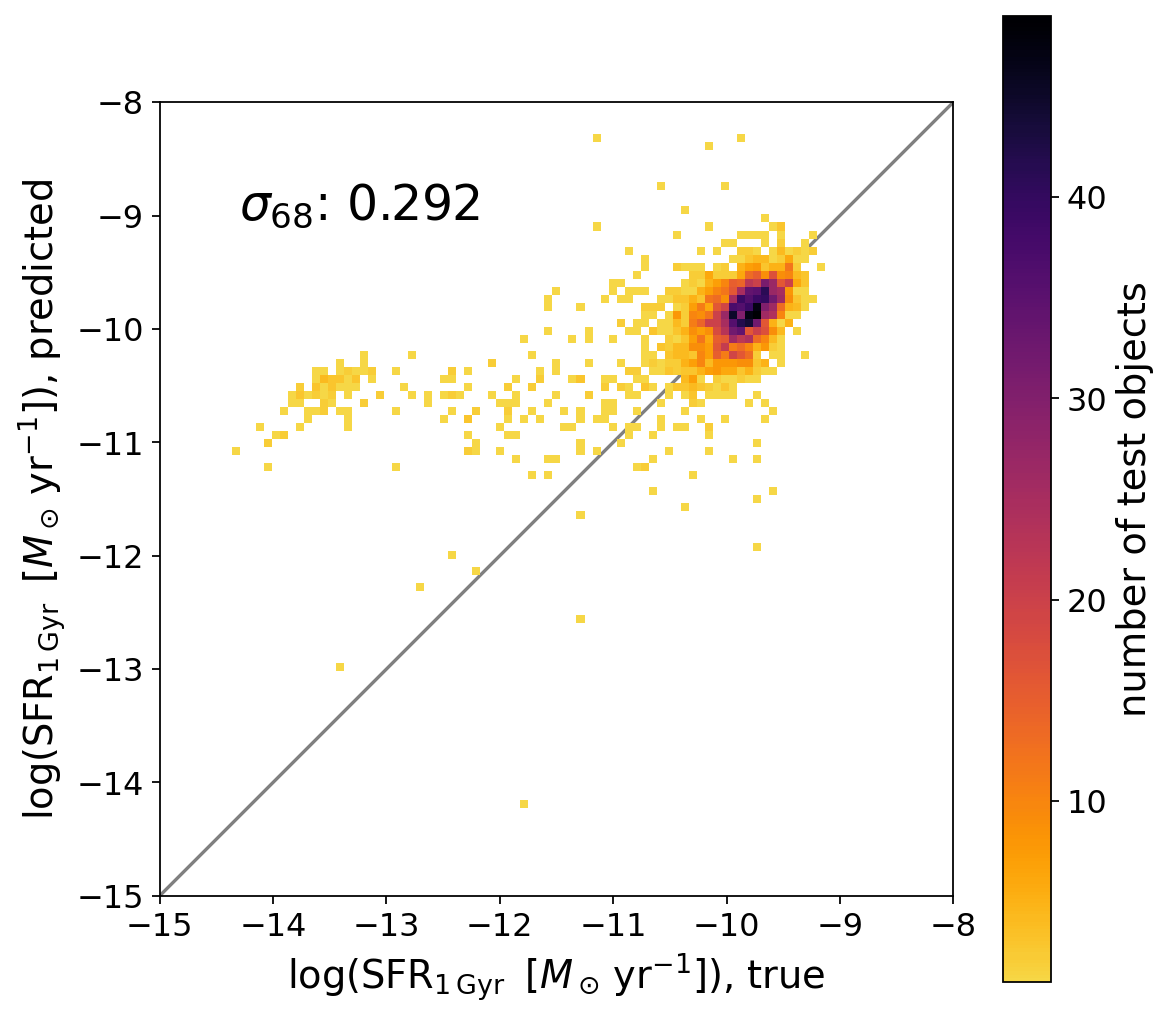

In [77]:
y_true = fitter_all_nopl.y_scalar_test
y_pred = fitter_all_nopl.y_scalar_pred
error_str = fr"$\sigma_{{68}}$: {error_all_nopl:.3f}"
plotter.plot_pred_vs_true_hist(y_label_name, y_true, y_pred, text_results=error_str,
                               x_lim=(-15, -8),  y_lim=(-15, -8))